# Visual Inspection of Motorcycle Connecting Rods.

author:
- Samuele Marino

## Introduction

Given a series of different images, for each image the program is able to identify all the information required for the scope of the project. To achieve the goal, we used computer vision techniques to separate the joined rods, eliminate noise from the images and ignore objects that should not be analyzed. The programme is able to identify the following information for each image:
- Type of rod
- Position and orientation
- Length, Width, Width at the barycentre
- For each hole, position of the centre and diameter size.

## Import libraries And Preparation images


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt, atan2, cos, sin, pi, tan, degrees
import math
import os

Preparation of the folder's path and the ids of the images for each task:

In [2]:
# folder_path = './img/'
folder_path = '/home/sam/UNIVERSITA/CVIP/ProjectWork/Visual-Inspection-of-Motorcycle-Connecting-Rods/img'


task_one = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'TESI33.BMP']
task_two1 = ['TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP']
task_two2 = ['TESI50.BMP', 'TESI51.BMP']
task_two3 = ['TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']

Creation of a routine to load all images on a dict:

In [3]:
def load_images_from_folder(folder):
  images = {}
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:  # Sanity check
      images[filename] = img
  return images


In [4]:
imgs_dict = load_images_from_folder(folder_path)

Visualization function

In [5]:
def img_show(dict, task, nrows=1, ncols=6, figsize=(25, 10)):
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  for ax, key in zip(axs.flat, task):
    ax.imshow(dict[key], cmap='gray')
    ax.set_title(str(key))
    
  plt.tight_layout()
  plt.show()

## First Task

The Images contain only connecting rods, which can be of both types and feature significantly diverse dimensions.

Connecting rods have been carefully placed within the inspection area so to appear well separated in images
Images have been taken by the backlighting technique so to render rods easily distinguishable from background.

However, for flexibility reasons the system should not
require any change to work properly with lighting sources of different power.

This task work with these images:
Tesi00.bmp, Tesi01.bmp, Tesi12.bmp, Tesi21.bmp, Tesi31.bmp, Tesi33.bmp.

### Visualization of the images of the first task:

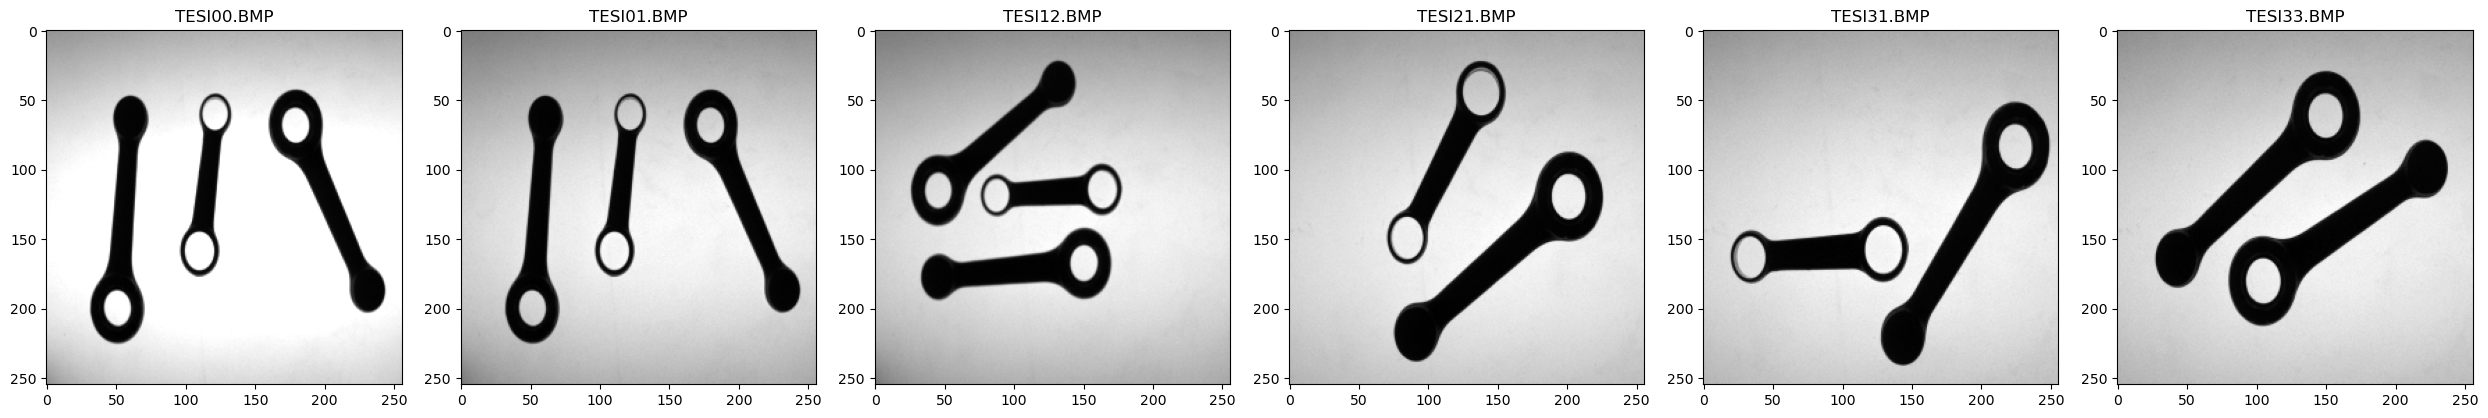

In [6]:
img_show(imgs_dict, task_one)

### Image segmentation


The segmentation is done to distinguish the information part related to the rods even though the images were taken with the backlight technique
and the rods are easily distinguishable from the background. Binarization techniques allow to separate the object from the background and then analyse only the pixels of the object. Considering the various techniques with which segmentation can be performed, we decided to use the Otsu algorithm already implemented in the OpenCv library.
We use this algorithm because it automatically determines the threshold value. Otzu is advantageous because it allows a different threshold for each image and adapts the
threshold more easily to variations in illumination.

Perform the binarization of the image through the Otsu algorithm:

In [7]:
seg_dict = {}

for key in task_one:
  seg_dict[key] = cv2.threshold(imgs_dict[key], 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

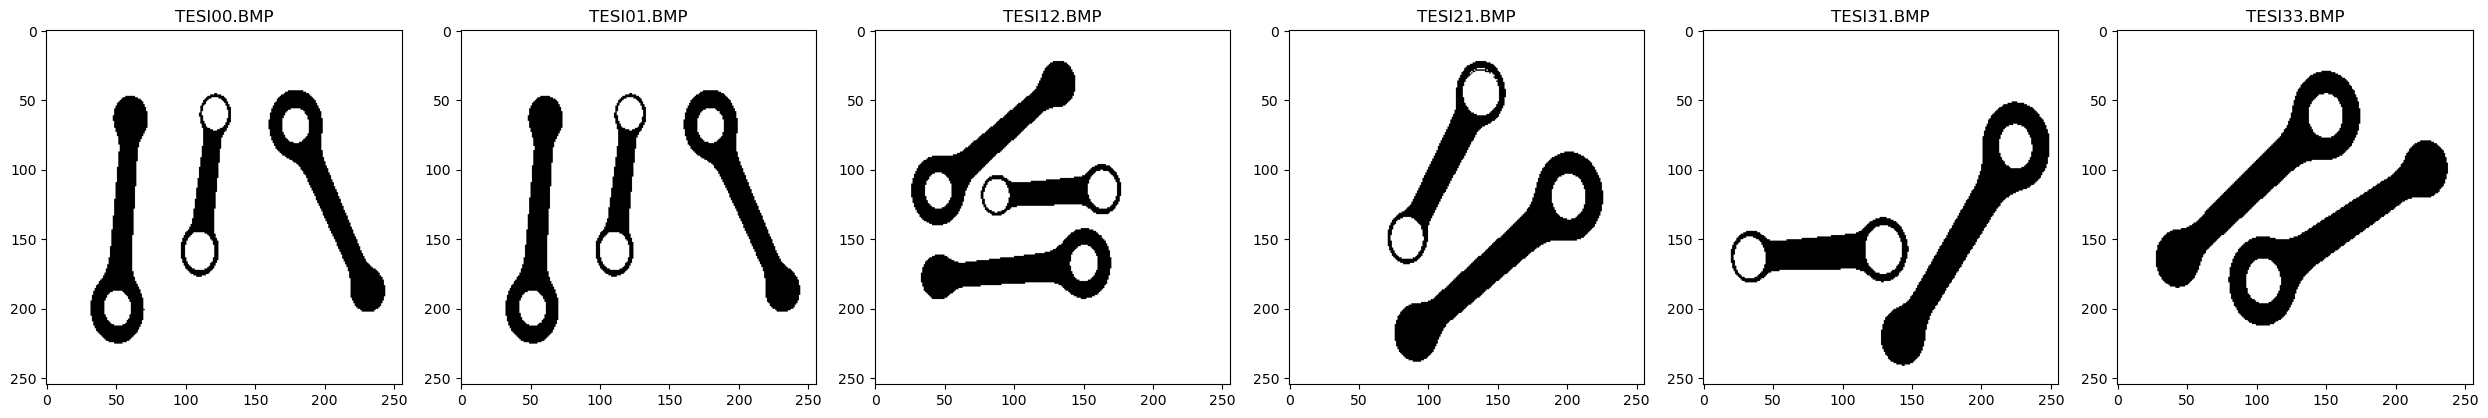

In [8]:
img_show(seg_dict, task_one)

Invert black and white in order to let the function findContours find the proper contours:

In [9]:
for key in task_one:
  seg_dict[key] = 255 - seg_dict[key]

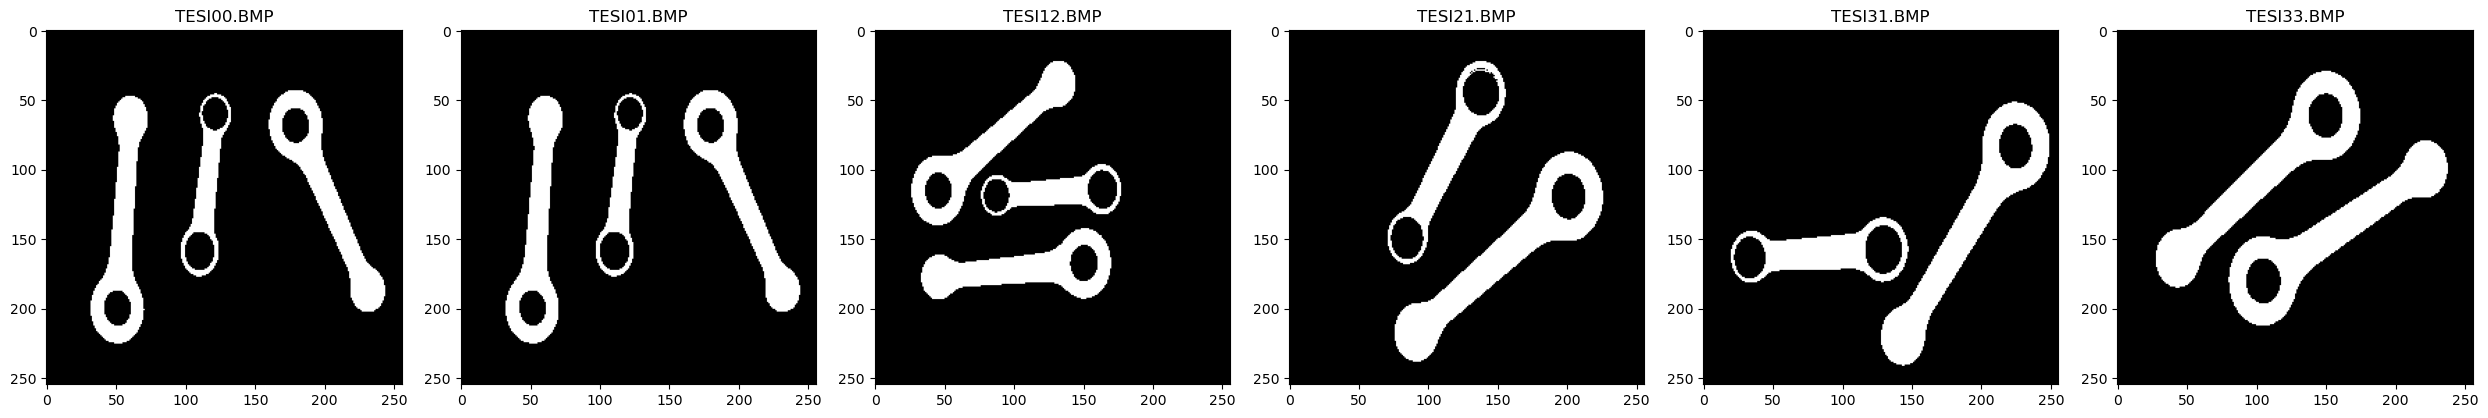

In [10]:
img_show(seg_dict, task_one)

### Extraction of connective rods

In order to complete the extraction of the objects and isolate the connecting rods I use the connectedComponentsWithStats() function.

In [11]:
status_dict = {}

for key in task_one:
  status_dict[key] = {}
  status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'] = cv2.connectedComponentsWithStats(seg_dict[key], connectivity = 4)


The following function takes the number of connected components plus the background, the labels, the statistics on the components and  shows the different connected components with an enclosing rectangle.
It separates the images in different channels, one for each label, assigns a new label to show a different colour and then concatenates the channels back;

In [12]:
def drow_components(num_labels, labels, stats):
  # Assign different colours in a balanced way
  label_hue = np.uint8(179 * labels / np.max(labels))
  blank_ch = 255 * np.ones_like(label_hue)
  
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
  labeled_img[label_hue == 0] = 0
  
  return labeled_img
    

In [13]:
connect_dict = {}

for key in task_one:
  connect_dict[key] = drow_components(status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats']) 

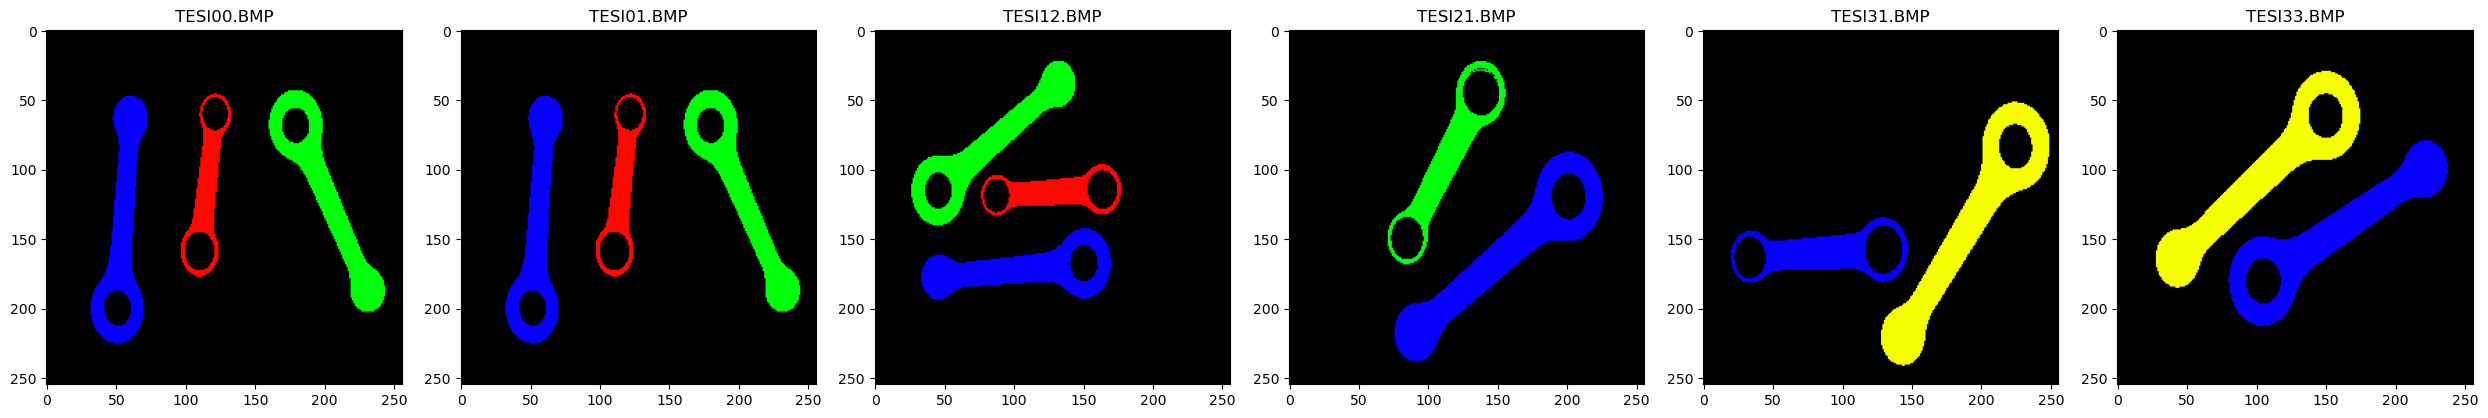

In [14]:
img_show(connect_dict, task_one)

### Position and Orientation

To calculate the position of the connecting rods, we need to found the barycentre of each connecting rod. The function getOrientation() finds the barycentre and uses the Principal Component Analysis algorithm to find the orientation of the connecting rod. This algorithm takes as input the vector of foreground points of the connecting rod and projects these points onto two new reference axes. The first axis represents the highest variance and the second axis represents the lowest variance. We then calculated eigenvectors and eigenvalues of the covariance matrix to identify the orientation of the major and minor axis relative to the horizontal axis.

In [15]:
def getOrientation(pts, img):
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
      data_pts[i,0] = pts[i,0,0]
      data_pts[i,1] = pts[i,0,1]
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  cv2.circle(img, cntr, 3, (255, 0, 255), 1)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  draw_axis(img, cntr, p1, (255, 255, 255), 1)
  draw_axis(img, cntr, p2, (255, 255, 255), 5)
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radiants
  label = str(cntr[0])+ ' ' + str(cntr[1])
  labelAngle=  str(round(angle,2)) + ' radiants'
  cv2.putText(img, text=label , org=(cntr[0], cntr[1]), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(255, 255, 255),thickness=1)
  cv2.putText(img, text=labelAngle , org=(cntr[0], cntr[1]+10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(255, 255, 255),thickness=1)
  
  return angle

Function used to draw the major and minor axes on the image

In [16]:
def draw_axis(img, p_, q_, colour, scale):
  p = list(p_)
  q = list(q_)
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

### Length and Width

The getLenghtWidth() function finds the length and width of each connecting rod. To find this information we used the minAreaRect() function available in the OpenCV library. This function takes the foreground points as input and finds the enclosing rectangle of minimum size. We found the length and the width of the connecting rod by taking the length and the width of the enclosing rectangle drawn around the connecting rod.

In [17]:
def getLenghtWidth(contour):
  rect = cv2.minAreaRect(contour)
  height = int(rect[1][1])
  width = int(rect[1][0])
  if height > width:
    return height, width
  else:
    return width, height

### Width at the barycentre

In order to find the width at the barycentre of each connecting rod, we used information already calculated in the previous points, i.e. connecting rod contour, position of the barycentre and angle of inclination of the connecting rod. The getWidthAtBarycenter() function gets as input the position of the barycentre and the angle of the major axis. The function finds two points in particular by finding the intersection of the line passing through the barycentre, perpendicular to the major axis of the connecting rod, and the
points of the connecting rod contour. Then the width at the barycentre is equal to the distance between these two points.

In [18]:
def getWidthAtBarycenter(centroid, angle, contour):
  cVals = []
  m = tan(angle-math.pi/2)
  yp=centroid[1]
  xp=centroid[0]
  for j in range (0,len(contour)): 
    x,y=contour[j][0]
    value= distanceLinePointAngle(centroid, m, (x,y))
    if value<0.9:
      cVals.append((x,y))
  distances = []
  for i in cVals:
    distances.append(distance(cVals[0],i))
  width = min([k for k in distances if k > 2 ])
  return width

Function used to compute euclidean distance between two points in R2. p1 and p2: tuple of coordinates of the point (x,y)

In [19]:
def distance (p1,p2):
  return sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

Same function as the one above, but the line is identified from a point (center) and its angular coefficient

In [20]:
def distanceLinePointAngle(center, m, point):
  a=m
  b=-1
  c=center[1]-(m*center[0])
  distance = abs((a*point[0]) + (b*point[1])+c)/(sqrt(a**2+b**2))
  return distance

### Position of the center and diameter size for each hole

Once the contours have been extracted with the findContours() function,in particular the ones of the holes, since the holes have a circular shape, the center of each hole correspond to the barycenter of its contour. To find the diameter we calculated the distance between a random contour point and the centre of the hole. The holeAnalysis() function takes as input a connecting rod contour with its hierarchy and returns its position and diameter.

In [21]:
def holeAnalysis(c, h):
  child = h[0][0][2]
  centers = []
  diameters = []

  countHoles = 0
  while (child != -1):
    holeContour= c[child]
    area = cv2.contourArea(holeContour)
    if area>20:
      contourCenter = getContourCenter(holeContour)
      centers.append(contourCenter)
      diameters.append(distance(contourCenter,c[child][0][0]))
      countHoles += 1
    child = h[0][child][0]
  if countHoles != 1 and countHoles != 2:
    return 0
  else:
    return centers,diameters

Function that computes the barycenter of a contour

In [22]:
def getContourCenter(c):
  M = cv2.moments(c)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])
  return (cx,cy)

### Classification of roads

Connecting rods are classified according to the number of holes they have and we decided to use the findContours() function available in the OpenCV library. This function extracts the contours of the objects in the image and hierarchizes them into a tree. In the tree generated by the function, each node corresponds to a contour identified in the image. If in the image a
contour K is immediately contained in a contour L, then in the tree node K is a child of node L. In this way, after identifying the contour of a connecting rod, it is sufficient to recognize in the corresponding hierarchy how many children it has: 1 child only means it has only 1 hole and the rod is type A, 2 children means it has 2 holes and the rod is
type B.

In [23]:
def task(img, num_labels, labels, stats, centroids):
  img_copy = img.copy()
  rodNumber = 1
  text = ''
  for label in range(1,num_labels):
    area = stats[label,cv2.CC_STAT_AREA]
    if area>100:
      mask = np.zeros(labels.shape, dtype=np.uint8)
      mask[labels == label] = 255
      contiurn, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
      
      cv2.rectangle(img_copy, # Image
                      (stats[label][0], stats[label][1]), # Starting point
                      (stats[label][0] + stats[label][2], stats[label][1] + stats[label][3]), # Endinf point
                      (0, 255, 0), # Colour
                      2) # Thichness
      putNameOnRod(contiurn[0],img_copy, rodNumber)
      angle= getOrientation(contiurn[0],img_copy)
      widthAtB = getWidthAtBarycenter(centroids[label], angle, contiurn[0])
      lenght, width= getLenghtWidth(contiurn[0])
      aorb = getType(hierarchy)
      pos, diameters = holeAnalysis(contiurn, hierarchy)
      
      text += info(rodNumber, degrees(angle) % 180, width, lenght, aorb, pos, diameters, centroids[label], widthAtB)
      rodNumber += 1
    
  return img_copy, text

Function that computes the type of the connecting rod from its hierarchy of contours (h)

In [24]:
def getType(h):
  firstNested = h[0][0][2]
  if firstNested == -1:
    print('Error! Rod without holes!')
  elif h[0][firstNested][0] == -1:
    return 'A'
  else: 
    return 'B'

Function used to simply print the number of the rod on top of it in the image.

In [25]:
def putNameOnRod(c,img, number):
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  name = 'Rod ' + str(number)
  cv2.putText(img, text=name , org=(box[2][0], box[2][1]), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(255, 255, 255),thickness=1)

Function that create a string of all image's information

In [26]:
def info(number, angle, width, lenght, aorb, pos, diameters, centerPos, widthAtB):
  text = ''
  text += (f'Rod number {number} INFO:\n')
  text += (f'Rod type: {aorb}\n')
  x,y = centerPos
  text += (f'Position center of the rod: {round(x,2)},{round(y,2)}\n')
  text += (f'Angle: {round(angle,2)} degrees\n')
  text += (f'Lenght: {round(lenght,2)}\n')
  text += (f'Width: {round(width,2)}\n')
  text += (f'Width at barycenter: {round(widthAtB,2)}\n')
  for i in range (len(pos)):
    text += (f'Hole number {i + 1} is at position {pos[i]} with diameter of {round(diameters[i],2)}\n')
  return text

### Test

In [27]:
text = {}
result = {}

for key in task_one:
  result[key], text[key] = task(connect_dict[key], status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'])

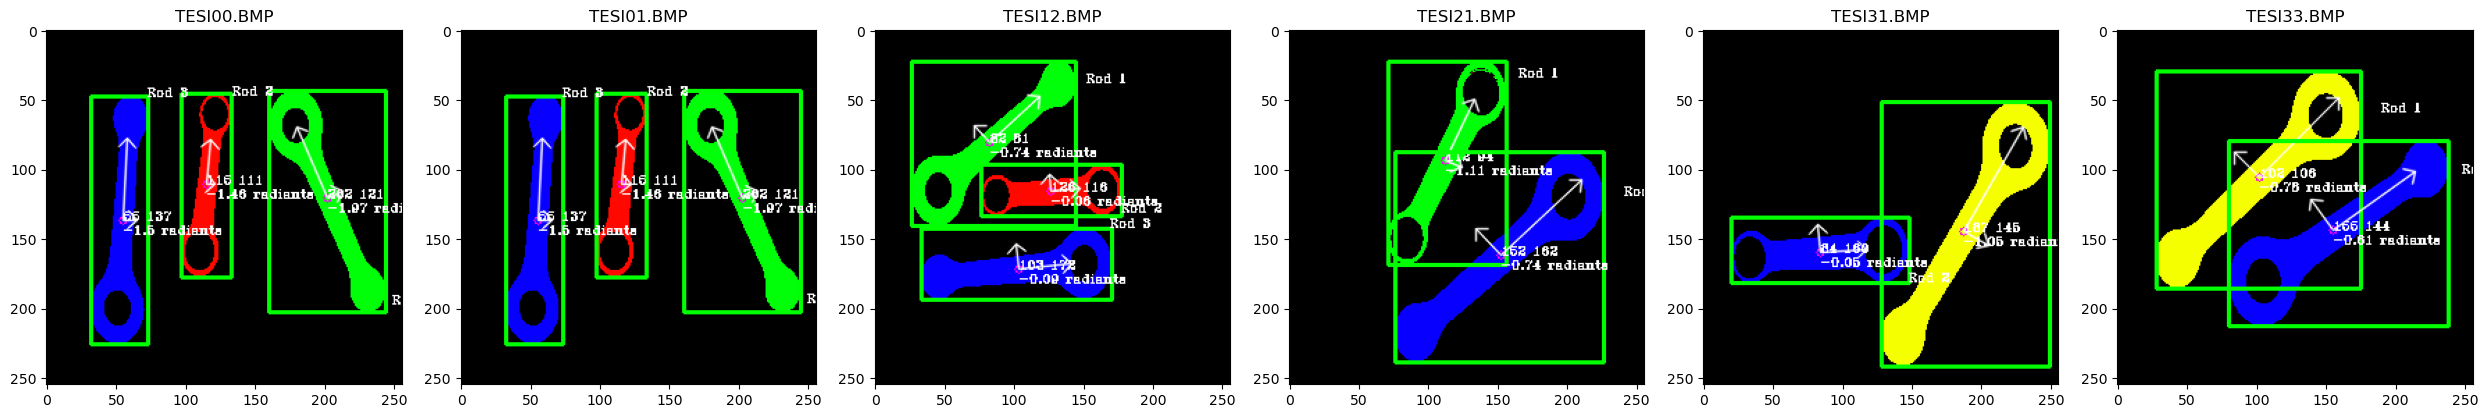

In [28]:
img_show(result, task_one)

In [29]:
for key in task_one:
  print(f'IMAGE: {key}')
  print(text[key])
  print('-'*110) 

IMAGE: TESI00.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 201.39,119.12
Angle: 67.05 degrees
Lenght: 169
Width: 39
Width at barycenter: 15.23
Hole number 1 is at position (179, 68) with diameter of 11.7
Rod number 2 INFO:
Rod type: B
Position center of the rod: 115.22,114.18
Angle: 96.35 degrees
Lenght: 131
Width: 26
Width at barycenter: 13.15
Hole number 1 is at position (109, 158) with diameter of 12.65
Hole number 2 is at position (121, 60) with diameter of 11.4
Rod number 3 INFO:
Rod type: A
Position center of the rod: 54.83,141.36
Angle: 93.9 degrees
Lenght: 177
Width: 38
Width at barycenter: 14.04
Hole number 1 is at position (50, 199) with diameter of 11.4

--------------------------------------------------------------------------------------------------------------
IMAGE: TESI01.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 201.31,119.02
Angle: 67.05 degrees
Lenght: 169
Width: 39
Width at barycenter: 14.87
Hole number 1 is at position (178, 6

## Second Task

While still meeting the requirement of the First Task, students should modify the system in order to deal with one (or more) of the following three changes in the characteristics of the working images:
1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the
system (such kind of objects are often referred to in computer vision as “distractors”).
2. Rods can have contact points but do not overlap one to another.
3. The inspection area may be dirty due to the presence of scattered iron powder.


This task work with these images:
1. Tesi44.bmp, Tesi47.bmp, Tesi48.bmp, Tesi49.bmp.
2. Tesi50.bmp, Tesi51.bmp.
3. Tesi90.bmp, Tesi92.bmp, Tesi98.bmp.

### First Variant

Within the first variant, the system should be able to take into account of some other components, called distractors, that should be ignored along the analysis.

So I create function isARod() that filter element by area because road have a bigger area and by circularity in order to exclude those round shapes


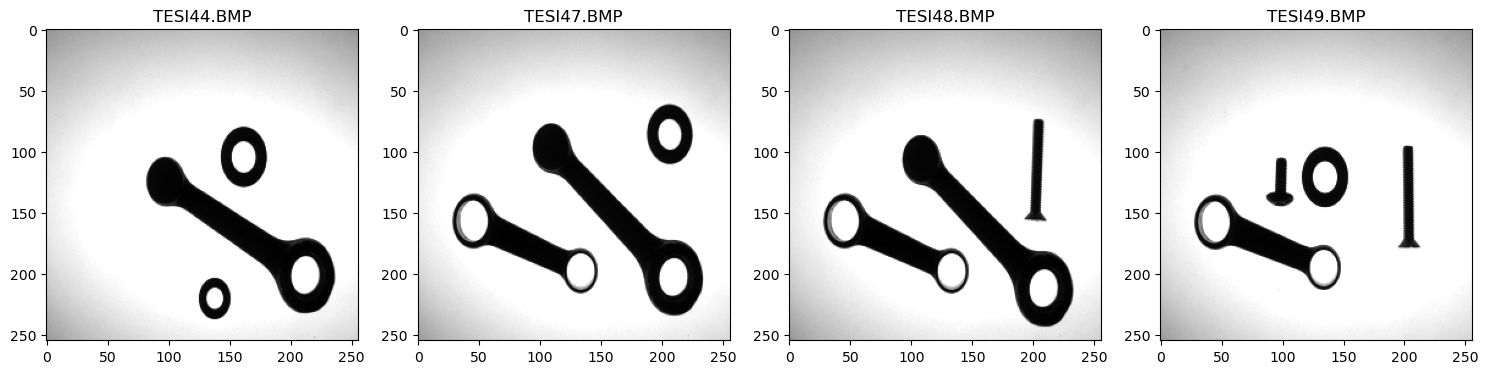

In [30]:
img_show(imgs_dict, task_two1, nrows=1, ncols=4, figsize=(15, 10))

In [31]:
seg_dict = {}

for key in task_two1:
  seg_dict[key] = cv2.threshold(imgs_dict[key], 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

for key in task_two1:
  seg_dict[key] = 255 - seg_dict[key]

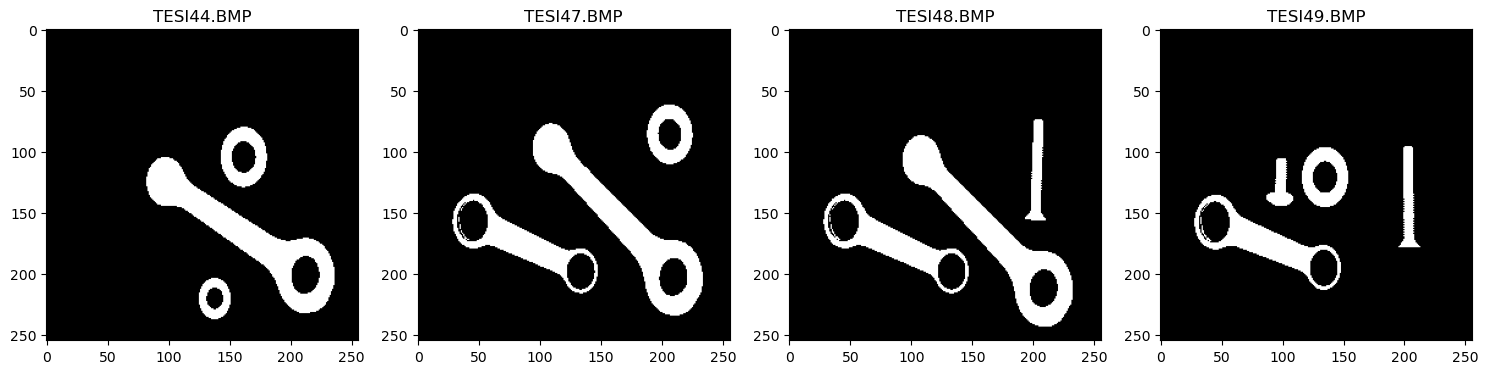

In [32]:
img_show(seg_dict, task_two1, nrows=1, ncols=4, figsize=(15, 10))

In [33]:
status_dict = {}

for key in task_two1:
  status_dict[key] = {}
  status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'] = cv2.connectedComponentsWithStats(seg_dict[key], connectivity = 4)

connect_dict = {}

for key in task_two1:
  connect_dict[key] = drow_components(status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats']) 

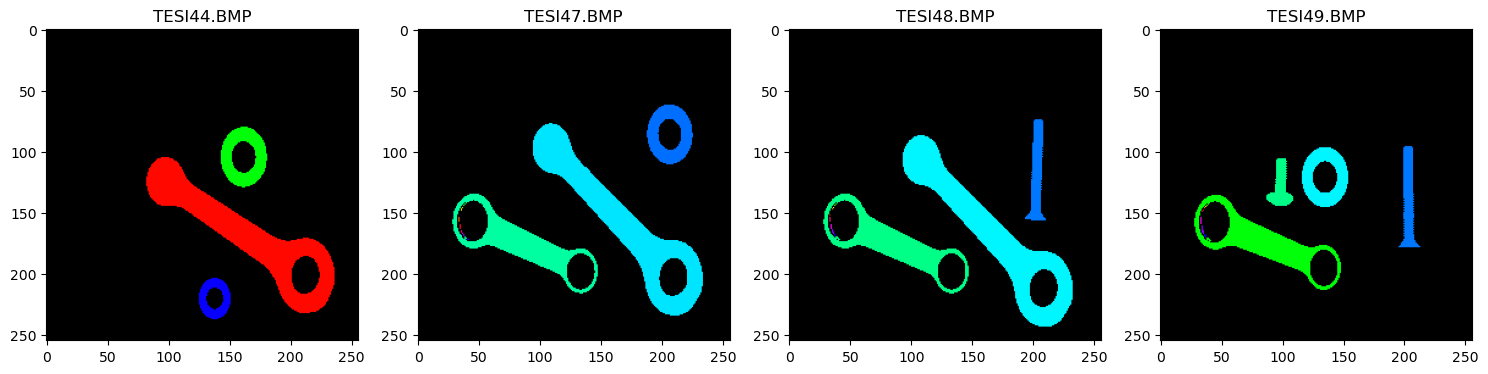

In [34]:
img_show(connect_dict, task_two1, nrows=1, ncols=4, figsize=(15, 10))

In [35]:
def task(img, num_labels, labels, stats, centroids):
  img_copy = img.copy()
  rodNumber = 1
  text = ''
  for label in range(1,num_labels):
    area = stats[label,cv2.CC_STAT_AREA]
    if area>100:
      mask = np.zeros(labels.shape, dtype=np.uint8)
      mask[labels == label] = 255
      contourn, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
      if isARod(contourn[0], hierarchy):
        cv2.rectangle(img_copy, # Image
                      (stats[label][0], stats[label][1]), # Starting point
                      (stats[label][0] + stats[label][2], stats[label][1] + stats[label][3]), # Endinf point
                      (0, 255, 0), # Colour
                      2) # Thichness
        putNameOnRod(contourn[0],img_copy, rodNumber)
        angle= getOrientation(contourn[0],img_copy)
        widthAtB = getWidthAtBarycenter(centroids[label], angle, contourn[0])
        lenght, width= getLenghtWidth(contourn[0])
        aorb = getType(hierarchy)
        pos, diameters = holeAnalysis(contourn, hierarchy)

        text += info(rodNumber, degrees(angle) % 180, width, lenght, aorb, pos, diameters, centroids[label], widthAtB)
        rodNumber += 1
      else:
        cv2.rectangle(img_copy, # Image
                      (stats[label][0], stats[label][1]), # Starting point
                      (stats[label][0] + stats[label][2], stats[label][1] + stats[label][3]), # Endinf point
                      (255, 0, 0), # Colour
                      1) # Thichness
    
  return img_copy, text

In [36]:
def isARod(c, h):
  perimeter = cv2.arcLength(c, True)
  if perimeter == 0:
    return False
  area = cv2.contourArea(c)
  circularity = 4*math.pi*(area/(perimeter*perimeter))
  if area < 1000 or 0.7 < circularity < 1.2:
    return False
  else:
    return True

In [37]:
text = {}
result = {}

for key in task_two1:
  result[key], text[key] = task(connect_dict[key], status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'])

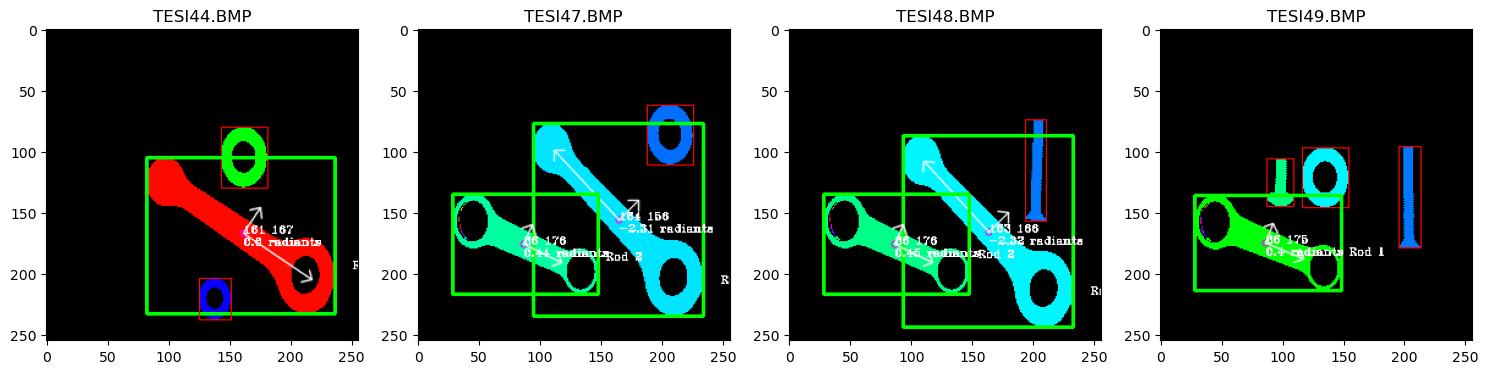

In [38]:
img_show(result, task_two1, nrows=1, ncols=4, figsize=(15, 10))

In [39]:
for key in task_two1:
  print(f'IMAGE: {key}')
  print(text[key])
  print('-'*110) 

IMAGE: TESI44.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 162.5,168.53
Angle: 34.51 degrees
Lenght: 182
Width: 56
Width at barycenter: 21.4
Hole number 1 is at position (211, 201) with diameter of 15.13

--------------------------------------------------------------------------------------------------------------
IMAGE: TESI47.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 165.75,157.84
Angle: 47.41 degrees
Lenght: 192
Width: 53
Width at barycenter: 21.21
Hole number 1 is at position (208, 202) with diameter of 14.32
Rod number 2 INFO:
Rod type: B
Position center of the rod: 84.43,175.08
Angle: 25.45 degrees
Lenght: 129
Width: 42
Width at barycenter: 21.47
Hole number 1 is at position (132, 198) with diameter of 14.32
Hole number 2 is at position (44, 156) with diameter of 16.0

--------------------------------------------------------------------------------------------------------------
IMAGE: TESI48.BMP
Rod number 1 INFO:
Rod type: A
Position center

### Second Variant

Within the second variant, the system should be able to take into account some touching rods.

An endeavour with morphological operators was attempted (in particular with erosion), with several structuring elements. Nevertheless, the erosion degraded too much the head of the rods, making the analysis fails.

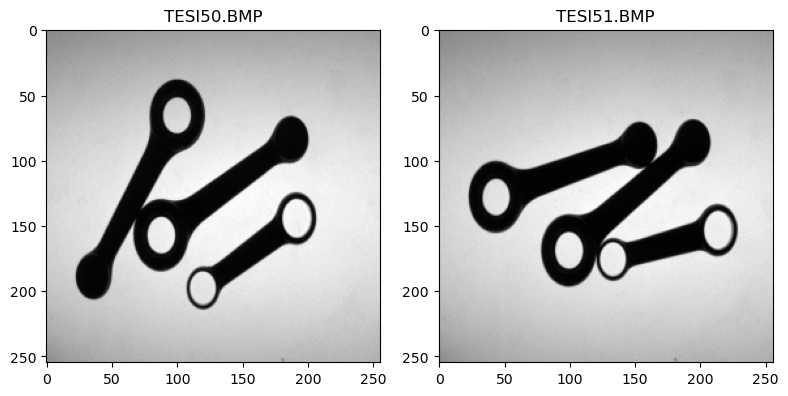

In [40]:
img_show(imgs_dict, task_two2, nrows=1, ncols=2, figsize=(8, 5))

In [41]:
seg_dict = {}

for key in task_two2:
    seg_dict[key] = cv2.threshold(imgs_dict[key], 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

for key in task_two2:
    seg_dict[key] = 255 - seg_dict[key]

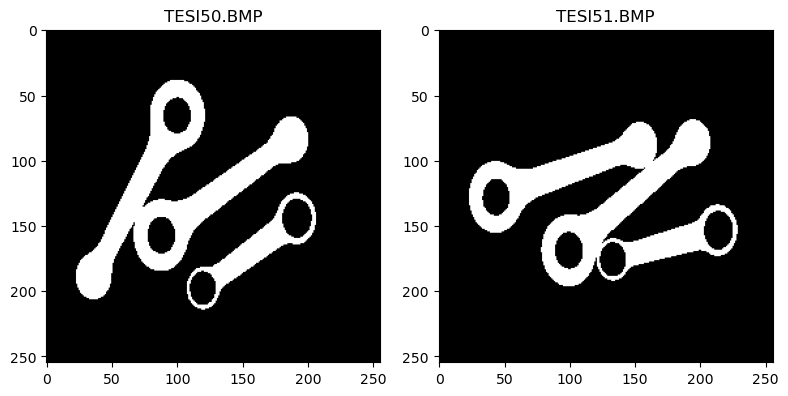

In [42]:
img_show(seg_dict, task_two2, nrows=1, ncols=2, figsize=(8, 5))

In [43]:
def erosion(img):
  image = img.copy()

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  image = cv2.erode(img, kernel, iterations = 3)

  return image

In [44]:
erose_dict = {}

for key in task_two2:
    erose_dict[key] = erosion(seg_dict[key])

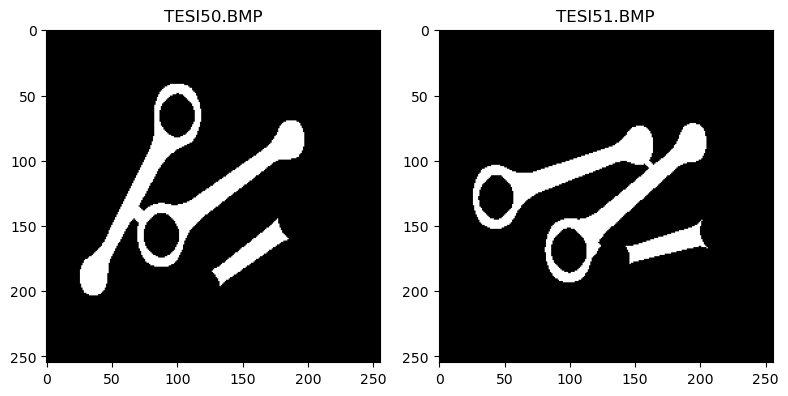

In [45]:
img_show(erose_dict, task_two2, nrows=1, ncols=2, figsize=(8, 5))

### Third Variant

To remove the iron dust present in some of the images in the dataset, I decided to use the median filter. In particular, medianBlur() provided by the OpenCv library has been used.I have chosen the median filter because it is very advantageous
in eliminating impulse noise. This non-linear filter works very well on this type of image because this powder introduces outliers into the image. The median filter was applied by a cascade method because some noise components were not easily removed. Exactly we applied the median filter 5 times in order to have a total removal of noise on all the images involved.

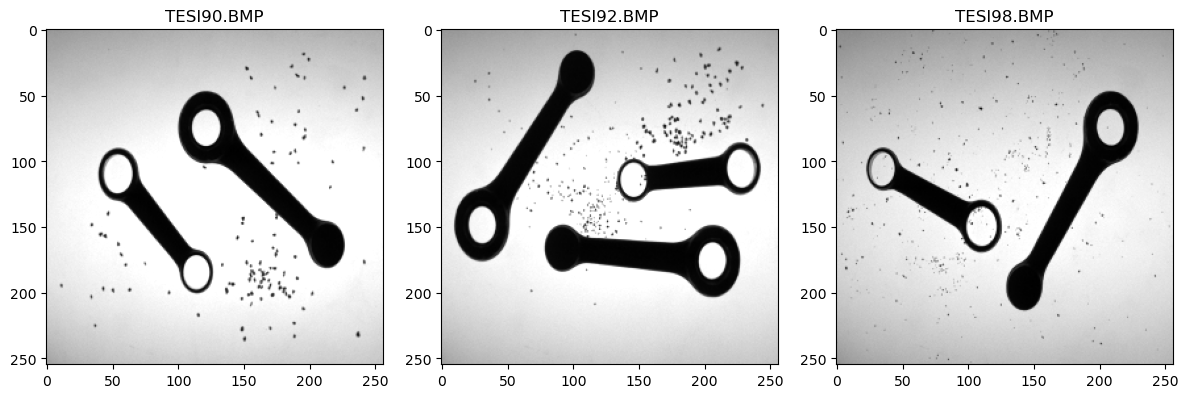

In [46]:
img_show(imgs_dict, task_two3, nrows=1, ncols=3, figsize=(12, 7))

In [47]:
def removeNoise(img):
  img = cv2.medianBlur(img, 3)
  img = cv2.medianBlur(img, 3)
  img = cv2.medianBlur(img, 3)
  img = cv2.medianBlur(img, 3)
  img = cv2.medianBlur(img, 3)
  return img

In [48]:
for key in task_two3:
  imgs_dict[key] = removeNoise(imgs_dict[key])

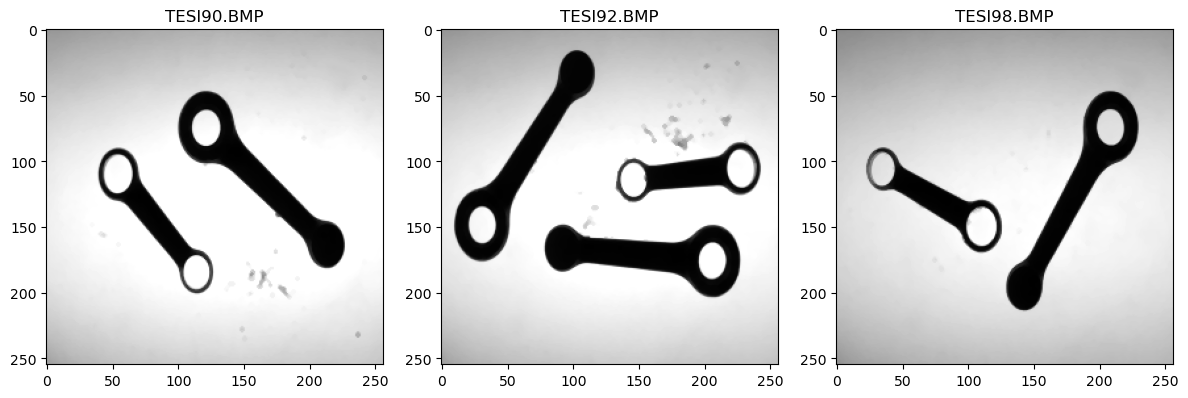

In [49]:
img_show(imgs_dict, task_two3, nrows=1, ncols=3, figsize=(12, 7))

In [50]:
seg_dict = {}

for key in task_two3:
  seg_dict[key] = cv2.threshold(imgs_dict[key], 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

for key in task_two3:
  seg_dict[key] = 255 - seg_dict[key]

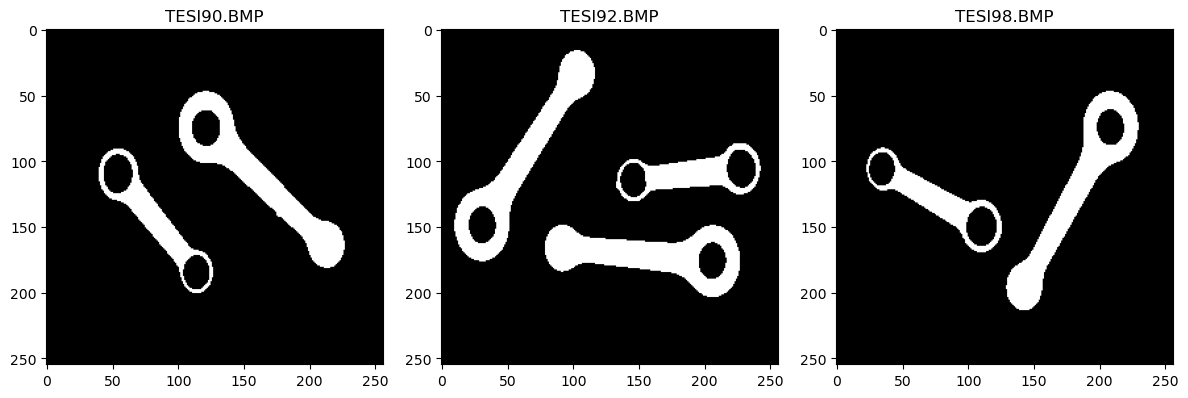

In [51]:
img_show(seg_dict, task_two3, nrows=1, ncols=3, figsize=(12, 7))

In [52]:
status_dict = {}

for key in task_two3:
  status_dict[key] = {}
  status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'] = cv2.connectedComponentsWithStats(seg_dict[key], connectivity = 4)

connect_dict = {}

for key in task_two3:
  connect_dict[key] = drow_components(status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats']) 

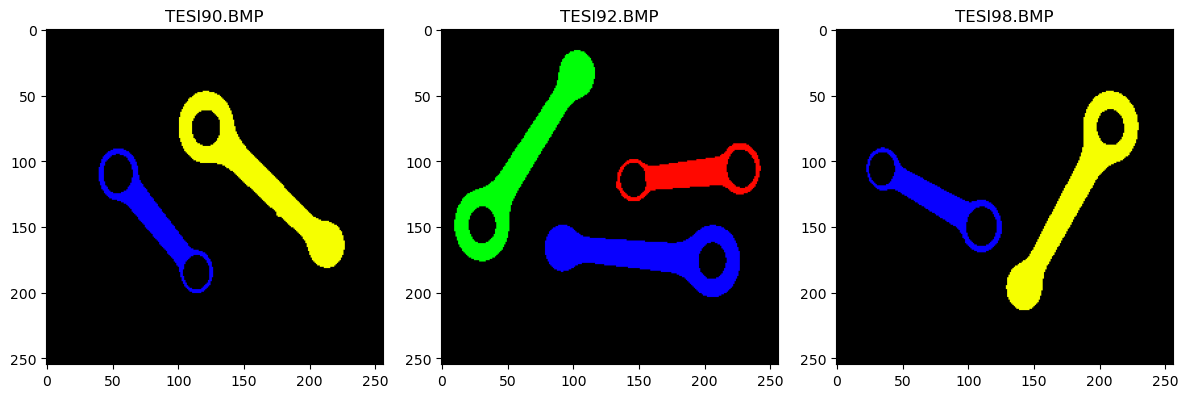

In [53]:
img_show(connect_dict, task_two3, nrows=1, ncols=3, figsize=(12, 7))

In [54]:
text = {}
result = {}

for key in task_two3:
  result[key], text[key] = task(connect_dict[key], status_dict[key]['num_labels'], status_dict[key]['labels'], status_dict[key]['stats'], status_dict[key]['centroids'])

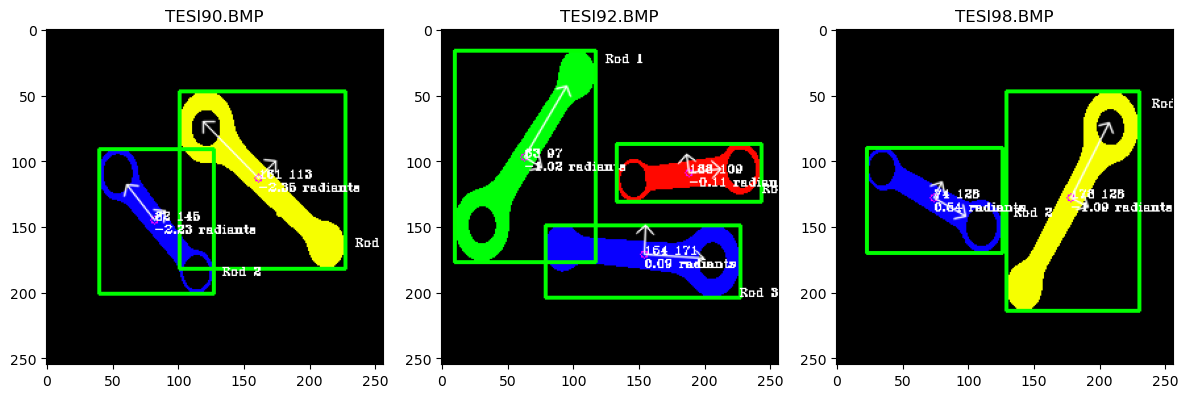

In [55]:
img_show(result, task_two3, nrows=1, ncols=3, figsize=(12, 7))

In [56]:
for key in task_two3:
  print(f'IMAGE: {key}')
  print(text[key])
  print('-'*110) 

IMAGE: TESI90.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 160.63,112.77
Angle: 45.1 degrees
Lenght: 168
Width: 47
Width at barycenter: 18.38
Hole number 1 is at position (121, 74) with diameter of 12.65
Rod number 2 INFO:
Rod type: B
Position center of the rod: 81.23,143.36
Angle: 52.06 degrees
Lenght: 128
Width: 33
Width at barycenter: 16.4
Hole number 1 is at position (113, 184) with diameter of 12.17
Hole number 2 is at position (54, 109) with diameter of 14.14

--------------------------------------------------------------------------------------------------------------
IMAGE: TESI92.BMP
Rod number 1 INFO:
Rod type: A
Position center of the rod: 61.84,98.75
Angle: 121.44 degrees
Lenght: 178
Width: 44
Width at barycenter: 17.49
Hole number 1 is at position (30, 148) with diameter of 13.15
Rod number 2 INFO:
Rod type: B
Position center of the rod: 190.24,109.81
Angle: 173.61 degrees
Lenght: 109
Width: 38
Width at barycenter: 19.03
Hole number 1 is at position (145,